# Constructing phylogenetic trees using Maximum Likelihood
This Jupyter notebook is created as a project in the Algorithms in Bioinformatics course 2018 given by [Swedish National Graduate School in Medical Bioinformatics](http://www.medbioinfo.se/).   
In this notebook I have 

1. Multiple Sequence Alignment
2. Generating a random Tree


So lets start with setting up the working environment

Tree topology
Branch lengths
Nucleotide frequencies
Nucleotide-nucleotide substitution rates


In [290]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Maximum Likelihood

### Multiple Sequence Alignment
The first step in creating a phylogenetic tree is to do a multiple sequence alignment (MSA) of the sequences that we want to include in our tree. This is done to find [homologous](https://en.wikipedia.org/wiki/Sequence_homology) posititions in the sequences, that is finding positions that have a shared ancestry. There are many  different tools for doing this, but the most common ones are [ClustalW](https://www.ebi.ac.uk/Tools/msa/clustalo/), [MUSCLE](https://www.ebi.ac.uk/Tools/msa/muscle/) and [MAFFT](https://www.ebi.ac.uk/Tools/msa/mafft/).
An MSA can be represented in many different ways and there are many different file formats for storing MSAs. The easiest way to represnt an MSA is to each row represent a sequnce in the alignment and each column represent a position in the alignment. If the alignment was done on the protein level each cell will contain either an ammino acid or a deletion sign, usually a -. In python we can represent an MSA as a dictionary where each key is the sequence identifier and each value is a list containing the element at each position in the alignment.
Next we will create a function that can read an MSA stored in a the plain text fasta-format.

In [26]:
def read_msa(path):
    """
    Read a multiple sequence alignment (MSA) in fasta format
    and returns a dictionary where each key is the sequence
    identifier and each value is a list with the elements
    of the alignmnent.
    
    Args:
    path (str) - Path to the fasta file.
    
    Return:
    msa (dict) - The MSA in a dictionary
    """
    msa = {}
    with open(path, 'r') as fasta_file:
        lines = fasta_file.readlines()
        for i in range(len(lines)):
            if lines[i][0] == '>':
                seq_id = lines[i][1:].strip()
                alignment = lines[i+1].strip()
                msa[seq_id] = list(alignment)
    
    return msa

In [53]:
msa = read_msa('./data/msa_test.faa')
print(msa)

{'Seq_C': ['C'], 'Seq_E': ['C'], 'Seq_B': ['A'], 'Seq_A': ['A'], 'Seq_D': ['G']}


### The simple case
We start with a simple case with an alignment of two sequences.

In [6]:
def calculate_jc_distance(substitutions, identical):
    """
    Calculate the distance between two sequences
    """
    distance = -(3/4) * np.log(1-(4/3) * (substitutions/(substitution + identical)))
    return distance

In [7]:
def count_substitutions(seq1, seq2):
    """
    Function to count the number of susbtitutions in a pairwise alignmnent
    """
    n_subst = 0
    for index in range(len(seq1)):
        if seq1[index] != seq2[index]:
            n_subst += 1
    return n_substitutions

In [206]:
def prob_no_mutation_jc(distance):
    """
    Calculate the probability to not observe a mutation for a given distance using Jukes-Cantor model
    """
    prob = (1/4) * (1 + 3*np.exp((-4/3) * distance))
    return prob

In [207]:
def prob_mutation_jc(distance):
    """
    Calculate the probability to observe a mutation for a given distance using Jukes-Cantor model.
    """
    prob = (1/4) * (1 - np.exp((-4/3) * distance))
    return prob

### Tree structure

In [318]:
class Node:
    def __init__(self, alignment_length, alignment=False, left=None, right=None, center=None):
        self.left = left
        self.right = right
        self.center = center
        self.length = 0.1
        self.alignment_seq = alignment
        self.alignment_length = alignment_length 
        self.nucl_map = {'A':0, 'C':1, 'G':2, 'T':3}
        self.set_nucl_probs()
        
        
    def set_nucl_probs(self):   
        if self.alignment_seq:
            self.nucl_prob = np.zeros((4, self.alignment_length)) 
            for index, nucleotide in enumerate(self.alignment_seq):
                row = self.nucl_map[nucleotide]
                self.nucl_prob[row, index] = 1  # observed nucleotide
        else:
            self.node_prob()
    
    def node_prob(self):
        # This function should be moved to the Tree class
        self.nucl_prob = np.zeros((4, self.alignment_length))
        for index in range(self.alignment_length):
            for s, nucl_node in enumerate(['A', 'C', 'G', 'T']):
                if self.center:  # only used for root node
                    center_prob = 0
                right_prob = 0
                left_prob = 0
                for x, nucl_children in enumerate(['A', 'C', 'G', 'T']):
                    if nucl_node == nucl_children:
                        right_prob += prob_no_mutation_jc(self.right.length) * self.right.nucl_prob[x, index]
                        left_prob += prob_no_mutation_jc(self.left.length) * self.left.nucl_prob[x, index]
                        if self.center:
                            center_prob += prob_no_mutation_jc(self.center.length) * self.center.nucl_prob[x, index]
                    else:
                        right_prob += prob_mutation_jc(self.right.length) * self.right.nucl_prob[x, index]
                        left_prob += prob_mutation_jc(self.left.length) * self.left.nucl_prob[x, index]
                        if self.center:
                            center_prob += prob_mutation_jc(self.center_distance) * self.center.nucl_prob[x, index] 
                if self.center:                 
                    self.nucl_prob[s, index] = np.sum(right_prob) * np.sum(left_prob) * np.sum(center_prob)
                else:
                    self.nucl_prob[s, index] = np.sum(right_prob) * np.sum(left_prob)

In [335]:
# http://www.lacim.uqam.ca/~chauve/Enseignement/BIF7001/H04/Documents/Settles-ML-Branches.pdf
# Must find how the first and second derivatives are calculated to finish this function.
def optimize_branch_length(node, tree):
    epsilon = 0.001
    original_length = length
    old_likelihood = 0
    done = False
    better = False
    it = 1
    ite = 0
    
    while it <4 and ite < 20 and not done:
        likelihood = compute_likelihood(tree)
        if likelihood > old_likelihood:
            old_length = y
            old_likelihood = likelihood
            better = True
            it += 1
        if better:
            node.length = node.length + first_derative/abs(second_derative)
        else:
            node.length = (node.length + 19 * yold)/20
        ite += 1
        if abs(node.length-old_length) < epsilon:
            done = True
    p_length = yold
    tree.log_likelihood = old_likelihood
    

In [334]:
class Tree:
    def __init__(self, aln):
        self.alignment = aln
        self.set_alignment_length()
        self.create_tree()
        self.log_likelihood = self.get_prob()
        
    def set_alignment_length(self):
        """
        
        """
        for aln in self.alignment.keys():
            self.alignment_length = len(self.alignment[aln])
            break
        
    def create_tree(self):
        """
        
        """
        nodes = []
        for seq in self.alignment.keys():
            node = Node(alignment_length=self.alignment_length, alignment=self.alignment[seq])
            nodes.append(node)
        
        while len(nodes) > 3:
            node = Node(alignment_length=self.alignment_length, left=nodes[0], right=nodes[1])
            nodes.pop(0)
            nodes.pop(0)
            nodes.append(node)
        
        self.root = Node(alignment_length=self.alignment_length, left=nodes[0], right=nodes[1], center=nodes[2])
        self.root.length = None
    
    def calculate_log_likelihood(self):
        # TODO: Instead of calculating the log-likelihood when the tree topology,
        # implement the Felsensteins pruning algorithm here. Then the log-likelihood
        # can be updated when there are changes in the branch lengths.
        """
        
        """
        print(np.sum(0.25 * self.root.nucl_prob.sum(axis=0)))
        log_likelihoods = np.log(0.25 * self.root.nucl_prob.sum(axis=0))
        return np.sum(log_likelihoods)

In [ ]:
# Implement a tree-traversal to visit all nodes to optimize the branch-lengths

In [320]:
aln = {'seq1':'CCAG', 'seq2':'CCTG', 'seq3':'CCAG', 'seq4':'GCAG', 'seq5':'ACAA', 'seq6':'CCTA'}
tree = Tree(aln)
print(tree.log_likelihood)
aln = {'seq1':'ACAG', 'seq2':'CCTG', 'seq3':'CCAG', 'seq4':'GCAG', 'seq5':'CCAA', 'seq6':'CCTA'}
tree = Tree(aln)
print(tree.log_likelihood)

0.10391849419151006
-27.943487826273014
0.10366980692593511
-29.000039572820285


### Felstein's pruning algorithm

In [82]:
for nucl in ['A', 'C', 'G', 'T']
node_prob[nucl] = node.right.prob(nucl) + node.left.prob(nucl)

-5.205091174921215

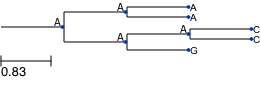

In [125]:
t.render('%%inline')